In [101]:
### Load packages and data files
import csv
import glob
from pprint import pprint 
import matplotlib.pyplot as plt
from collections import defaultdict, Counter
from dateutil import parser
import numpy as np
import math
import random
from operator import add
import scipy.stats

%matplotlib inline
plt.style.available
plt.style.use('ggplot')


In [102]:
## Function to Read all text files and Store in a List
def turnstile_read_csv(csv_files):
    dict_MTA= defaultdict(list)
    MTA = [] 
    for filename in glob.glob(csv_files):
        file = open(filename, 'r')
        reader = csv.reader(file)
        header = reader.next()
        MTA = list(reader)
        for turnstile in MTA:
            turnstile[-1].strip()     # Strip does not seem to work, fix later
            turnstile_key = tuple(turnstile[0:5])
            dict_MTA[turnstile_key].append(turnstile[5:])
        file.close()
    return dict_MTA


In [18]:
## Read all text files and Store in a List
dict_MTA = turnstile_read_csv("turnstile_*.txt")
pprint ({k: dict_MTA[k][:2] for k in dict_MTA.keys()[:2]})

{('JFK03', 'R536', '00-00-02', 'JFK JAMAICA CT1', 'E'): [['IND',
                                                          '06/04/2016',
                                                          '01:00:00',
                                                          'REGULAR',
                                                          '0000087367',
                                                          '0000079390                                       '],
                                                         ['IND',
                                                          '06/04/2016',
                                                          '05:00:00',
                                                          'REGULAR',
                                                          '0000087372',
                                                          '0000079392                                       ']],
 ('R238A', 'R046', '02-03-02', 'GRD CNTRL-42 ST', '4567S'): [['IRT',
          

## Get counts per interval

In [19]:
from datetime import datetime, date
from dateutil import parser
def time_series(dict_MTA):
    dict_MTA_ts = {}
    for key in dict_MTA.keys():
        dict_MTA_ts[key] = []
        for i in range(0, len(dict_MTA[key])):
            time = dict_MTA[key][i][1] + " " + dict_MTA[key][i][2]
            four_hr_ct = int(dict_MTA[key][i][4])- int(dict_MTA[key][i-1][4])
            #print "Count: %d" %four_hr_ct
            #gets entries and exits for each station
            four_hr_ct_entry = int(dict_MTA[key][i][4])- int(dict_MTA[key][i-1][4])
            four_hr_ct_exit = int(dict_MTA[key][i][5]) - int(dict_MTA[key][i-1][5])
            #checks that exits and entries are not negative and adds accordingly
            if four_hr_ct_entry < 0 or four_hr_ct_entry > 4*60*20 and four_hr_ct_exit < 0 or four_hr_ct_exit > 4*60*20:
                dict_MTA_ts[key].append([parser.parse(time), None])
            elif four_hr_ct_entry < 0 or four_hr_ct_entry > 4*60*20:
                dict_MTA_ts[key].append([parser.parse(time), four_hr_ct_exit])
            elif four_hr_ct_exit < 0 or four_hr_ct_exit > 4*60*20:
                dict_MTA_ts[key].append([parser.parse(time), four_hr_ct_entry])
            else:
                dict_MTA_ts[key].append([parser.parse(time), four_hr_ct_entry + four_hr_ct_exit])
    return dict_MTA_ts


In [20]:
small = dict((k, dict_MTA[k]) for k in (('N134', 'R385', '00-00-00', 'ROCKAWAY BLVD', 'A'), ('A006', 'R079' , '00-00-01' , '5 AV/59 ST','NQR')))
ts_small = time_series(small)
print ts_small[('N134', 'R385', '00-00-00', 'ROCKAWAY BLVD','A')][:10]
print ts_small[('A006', 'R079' , '00-00-01' , '5 AV/59 ST','NQR')][:10]

[[datetime.datetime(2016, 6, 4, 1, 0), None], [datetime.datetime(2016, 6, 4, 5, 0), 33], [datetime.datetime(2016, 6, 4, 9, 0), 226], [datetime.datetime(2016, 6, 4, 13, 0), 208], [datetime.datetime(2016, 6, 4, 17, 0), 261], [datetime.datetime(2016, 6, 4, 21, 0), 232], [datetime.datetime(2016, 6, 5, 1, 0), 125], [datetime.datetime(2016, 6, 5, 5, 0), 30], [datetime.datetime(2016, 6, 5, 9, 0), 140], [datetime.datetime(2016, 6, 5, 13, 0), 166]]
[[datetime.datetime(2016, 6, 4, 2, 0), None], [datetime.datetime(2016, 6, 4, 6, 0), 16], [datetime.datetime(2016, 6, 4, 10, 0), 146], [datetime.datetime(2016, 6, 4, 14, 0), 382], [datetime.datetime(2016, 6, 4, 18, 0), 592], [datetime.datetime(2016, 6, 4, 22, 0), 500], [datetime.datetime(2016, 6, 5, 2, 0), 110], [datetime.datetime(2016, 6, 5, 6, 0), 10], [datetime.datetime(2016, 6, 5, 10, 0), 112], [datetime.datetime(2016, 6, 5, 14, 0), 385]]


In [21]:
# Run all time series
dict_MTA_ts = time_series(dict_MTA)

### Combine stations and lines and attempt to adjust for incongruent line-station combos

In [22]:
# Fix some naming of station-lines, more needed on future steps
def convert(station, line):
    try:
        if station == "34 ST-PENN STA": return "123ACE"
        return {'ACJZ2345': '2345ACJZ', 'ACENQRS1237': '1237ACENQRS','AC1' : '1AC', 
         'JZ456' : '456JZ', 'BDNQR2345' : '2345BDNQR', 'ABCD1' : '1ABCD', 
         'R2345' : '2345R', 'LNQR456' : '456LNQR', 'BD4' : '4BD',
         'ACENGRS1237': '1237ACENQRS'}[line]
    except:
        return line

## Merge per station per morning of the week

In [23]:
def combine_into_stations(MTA):
    dict_station = defaultdict(list)
    for key in MTA:
        station_key = key[3] + " _ " + convert(key[3], key[4])
        #print station_key
        for interval in MTA[key]:
            #Eprint "Interval: ",
            #print interval 
            #print 14 >= interval[0].hour and interval[0].hour >= 8
            if(14 >= interval[0].hour and interval[0].hour >= 8):
                dict_station[station_key].append([interval[0].weekday(), interval[0].hour, interval[1]])
            #print dict_station
    return dict_station

In [24]:
station_small = combine_into_stations(ts_small)
print station_small   # for each day of the month [day f the week, time, count]

defaultdict(<type 'list'>, {'5 AV/59 ST _ NQR': [[5, 10, 146], [5, 14, 382], [6, 10, 112], [6, 14, 385], [0, 10, 411], [0, 14, 472], [1, 10, 324], [1, 14, 504], [2, 10, 466], [2, 14, 532], [3, 10, 432], [3, 14, 540], [4, 10, 420], [4, 14, 538], [5, 10, 139], [5, 14, 352], [6, 10, 93], [6, 14, 292], [0, 10, 422], [0, 14, 444], [1, 10, 389], [1, 14, 540], [2, 10, 439], [2, 14, 560], [3, 10, 453], [3, 14, 559], [4, 10, 376], [4, 14, 544], [5, 10, 136], [5, 14, 357], [6, 10, 82], [6, 14, 304], [0, 10, 334], [0, 14, 463], [1, 10, 427], [1, 14, 435], [2, 10, 438], [2, 14, 506], [3, 10, 443], [3, 14, 455], [4, 10, 372], [4, 14, 439], [5, 10, 143], [5, 14, 361], [6, 10, 106], [6, 14, 353], [0, 10, 458], [0, 14, 491], [1, 10, 449], [1, 14, 489], [2, 10, 414], [2, 14, 541], [3, 10, 384], [3, 14, 505], [4, 10, 349], [4, 14, 515]], 'ROCKAWAY BLVD _ A': [[5, 9, 226], [5, 13, 208], [6, 9, 140], [6, 13, 166], [0, 9, 688], [0, 13, 284], [1, 9, 754], [1, 13, 404], [2, 9, 765], [2, 13, 291], [3, 9, 664]

In [25]:
# Applying fn to merge per morning of week by station
dict_stations = combine_into_stations(dict_MTA_ts)
print dict_stations['5 AV/59 ST _ NQR']

[[5, 10, 146], [5, 14, 382], [6, 10, 112], [6, 14, 385], [0, 10, 411], [0, 14, 472], [1, 10, 324], [1, 14, 504], [2, 10, 466], [2, 14, 532], [3, 10, 432], [3, 14, 540], [4, 10, 420], [4, 14, 538], [5, 10, 139], [5, 14, 352], [6, 10, 93], [6, 14, 292], [0, 10, 422], [0, 14, 444], [1, 10, 389], [1, 14, 540], [2, 10, 439], [2, 14, 560], [3, 10, 453], [3, 14, 559], [4, 10, 376], [4, 14, 544], [5, 10, 136], [5, 14, 357], [6, 10, 82], [6, 14, 304], [0, 10, 334], [0, 14, 463], [1, 10, 427], [1, 14, 435], [2, 10, 438], [2, 14, 506], [3, 10, 443], [3, 14, 455], [4, 10, 372], [4, 14, 439], [5, 10, 143], [5, 14, 361], [6, 10, 106], [6, 14, 353], [0, 10, 458], [0, 14, 491], [1, 10, 449], [1, 14, 489], [2, 10, 414], [2, 14, 541], [3, 10, 384], [3, 14, 505], [4, 10, 349], [4, 14, 515], [5, 10, 67], [5, 14, 143], [6, 10, 47], [6, 14, 35], [0, 10, 228], [0, 14, 210], [1, 10, 227], [1, 14, 250], [2, 10, 250], [2, 14, 251], [3, 10, 248], [3, 14, 255], [4, 10, 212], [4, 14, 242], [5, 10, 65], [5, 14, 135

## Creates dictionary of format station:[avg count from Mon AM, for Tues AM, ...]

In [42]:
def days_of_week(dict_station):
    dict_by_day = defaultdict(list)
    for key in dict_station:
        day_counter = [0,0,0,0,0,0,0]
        dict_by_day[key] = [None,None,None,None,None,None,None]
        #print len(dict_station[key])
        
        for entry in dict_station[key]:
            day_counter[entry[0]]+=1
            #print dict_by_day[key]
            #print entry[2]
            if dict_by_day[key][entry[0]] == None and entry[2] != None:
                dict_by_day[key][entry[0]] = float(entry[2])
            elif entry[2] != None:
                dict_by_day[key][entry[0]] += float(entry[2])
        for i in range(0,7):
            dict_by_day[key][i] = round(dict_by_day[key][i]/(float(day_counter[i])/2),2)  
    #print day_counter
    
    return dict_by_day

In [43]:
days_small = days_of_week(station_small)
print days_small

defaultdict(<type 'list'>, {'5 AV/59 ST _ NQR': [873.75, 889.25, 974.0, 942.75, 888.25, 504.0, 431.75], 'ROCKAWAY BLVD _ A': [941.56, 1073.25, 1049.0, 958.0, 933.0, 567.25, 346.75]})


In [44]:
dict_by_days = days_of_week(dict_stations)
#print len(dict_by_days)
#print dict_by_days

## Prints out all stations to csv

In [29]:
#print dict_by_days.keys()
#import csv
with open('stations.csv','w') as file:
    writer = csv.writer(file, lineterminator=',')
    for i in dict_by_days.keys():
        writer.writerow([i])

## Create Dictionary by Neighborhood

In [45]:
neighbor_key=defaultdict()

with open ('Neighborhoods.csv') as csv_file:
    data=csv.reader(csv_file)
    for line in data:
        neighbor_key[line[0]]=line[1]

In [65]:
all_stations=neighbor_key.keys()
averages=dict_by_days    #### CHANGE OF VAR NAME

In [66]:
averages['125 ST _ 23']

[769.69, 760.53, 741.16, 650.89, 698.49, 428.31, 325.16]

In [67]:
neighbor_influx=defaultdict(list)

for station in neighbor_key.keys():
    hood = neighbor_key[station]
    if neighbor_influx[hood]:
        neighbor_influx[hood]= map(add, neighbor_influx[hood],averages[station])   ## Sum of averages!!!! 
    else:
        neighbor_influx[hood]=averages[station]

In [68]:
neighbor_influx['CHELSEA']

[11232.779999999999,
 11750.510000000002,
 11723.980000000001,
 11470.49,
 10652.99,
 4582.28,
 3452.34]

## Create Dictionary with neighborhoods as key and values as [weekday total, weekend total, week total]

In [104]:
def weekday_end_total(dic):
    by_week = defaultdict(list)
    for key in dic.keys():
        week = [0,0,0]
        for i in range(0, len(dic[key])):
            if i < 5:
                week[0]+= dic[key][i]
            else: 
                week[1]+= dic[key][i]
        week[2] = week[0] + week[1]
        
        by_week[key] = week
    return by_week

In [105]:
mta_neighbor = weekday_end_total(neighbor_influx)
mta_station = weekday_end_total(dict_by_days)

## Plot all neighborhoods by day of week

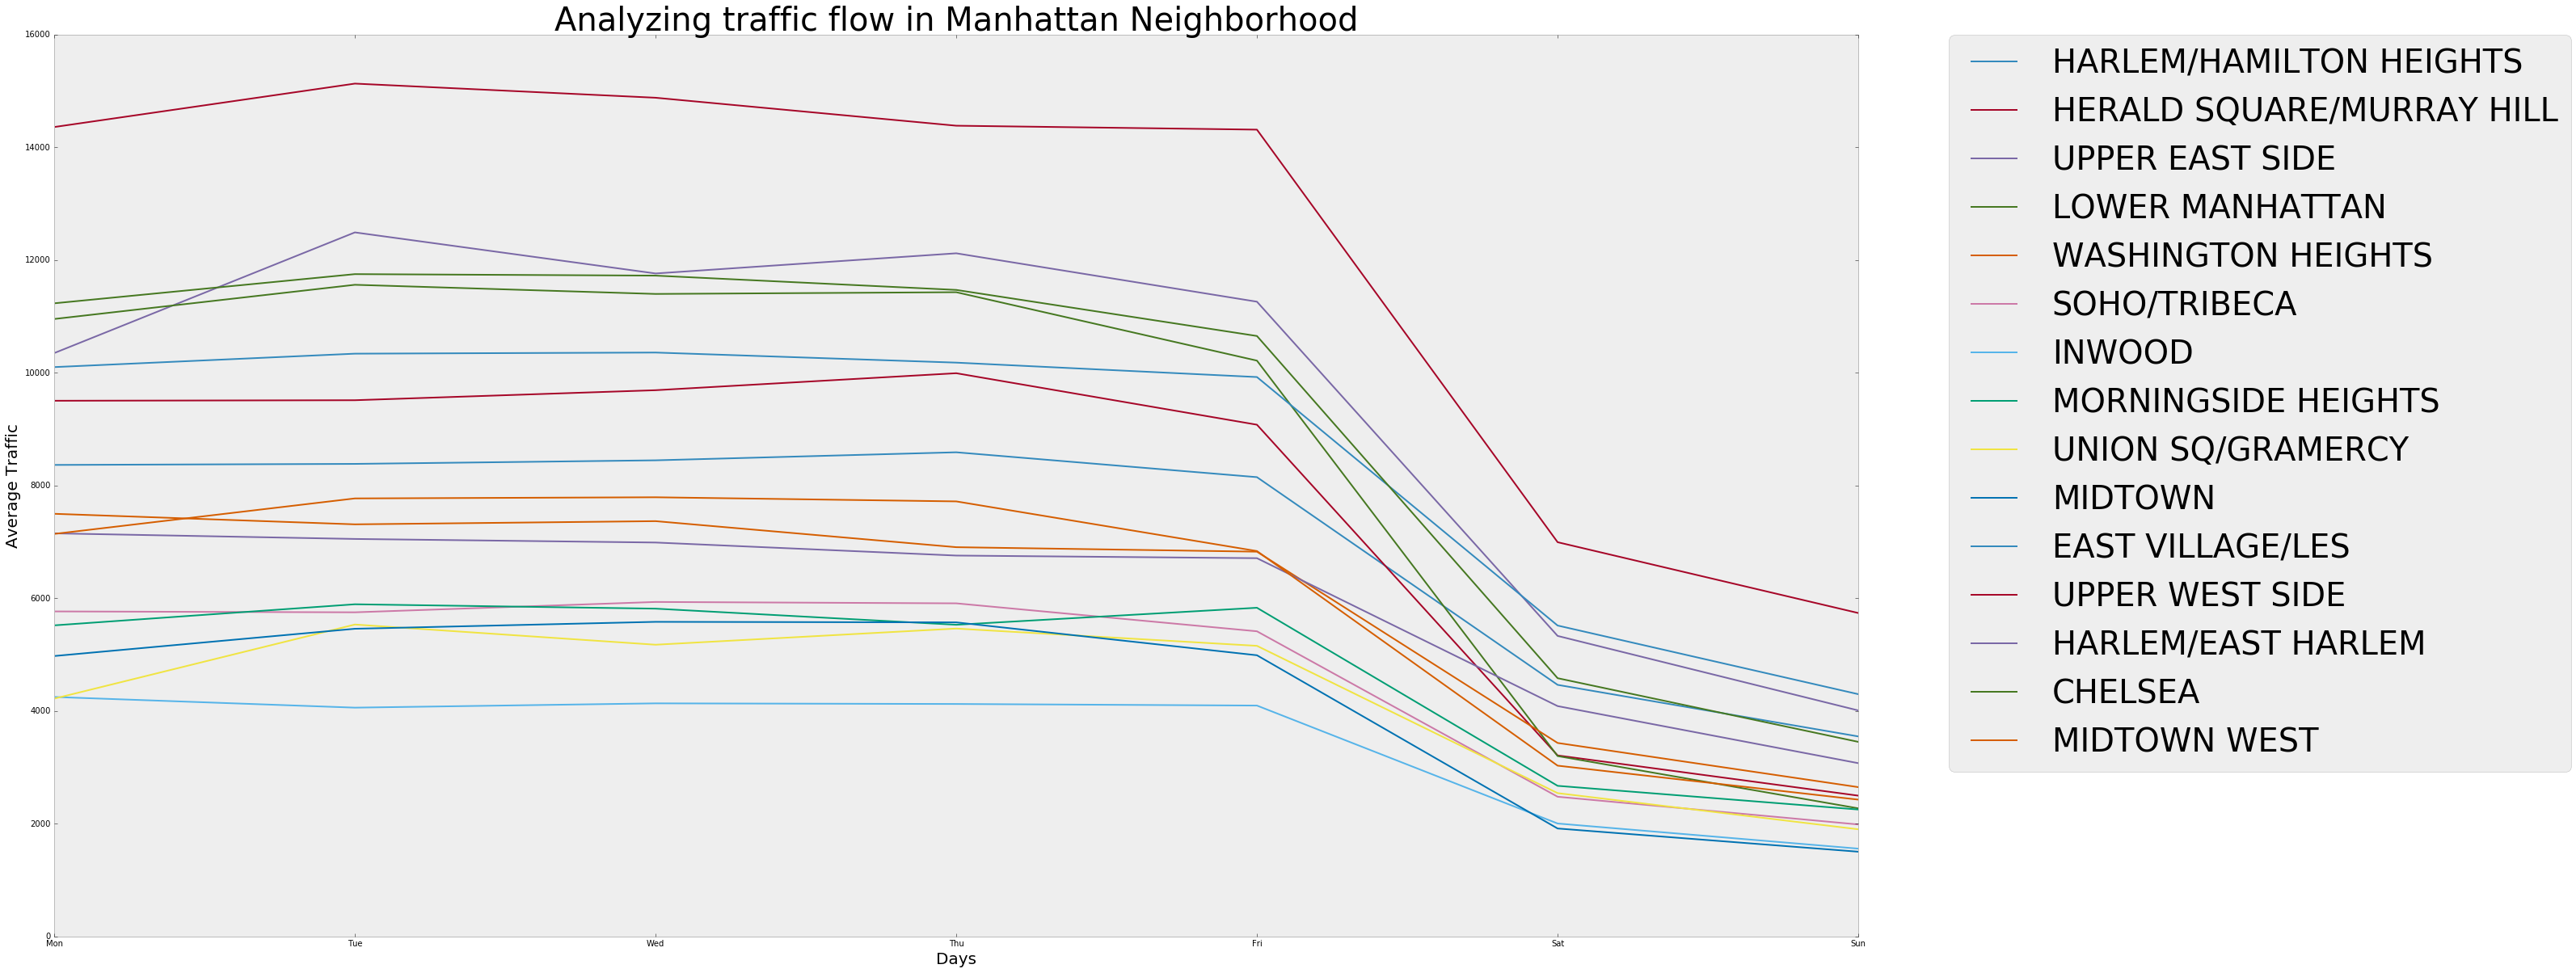

In [83]:
plt.figure(figsize=(40,20)) #initiate the plot 
for key in neighbor_influx:
    
    valList = neighbor_influx[key]
    x=[0,1,2,3,4,5,6]
    my_xticks = ['Mon','Tue','Wed','Thu','Fri','Sat','Sun']
    plt.xticks(x, my_xticks)
    plt.plot(x,valList, label=key)
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., prop = {'size':40})
    plt.xlabel('Days',fontsize=20) #add x label
    plt.ylabel('Average Traffic',fontsize=20) #add y label
    plt.title('Analyzing traffic flow in Manhattan Neighborhood',fontsize='40')
    
    plt.grid(False)
    #weekday sort histogram by most
    #weekend sort histogram by most 

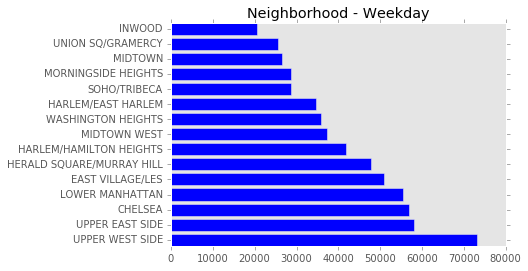

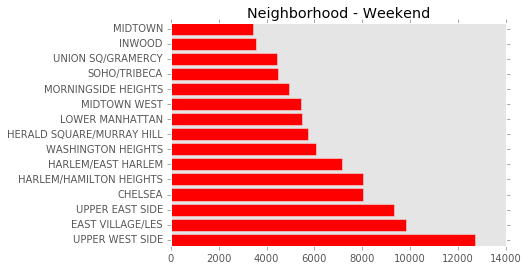

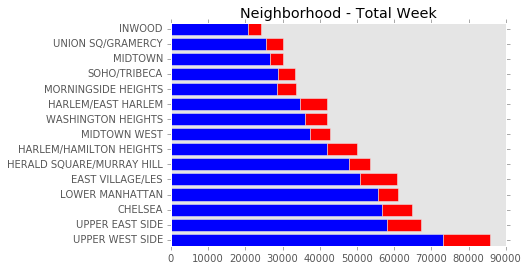

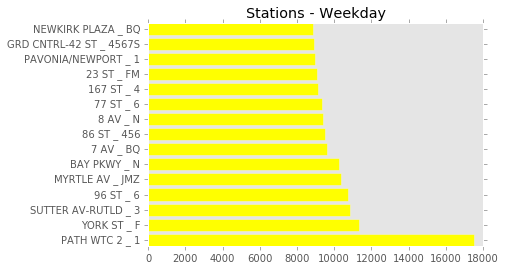

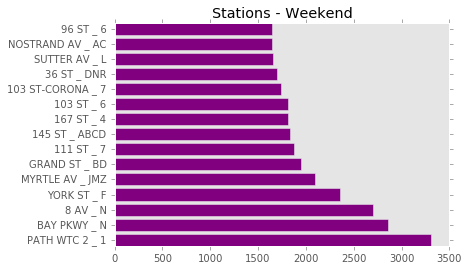

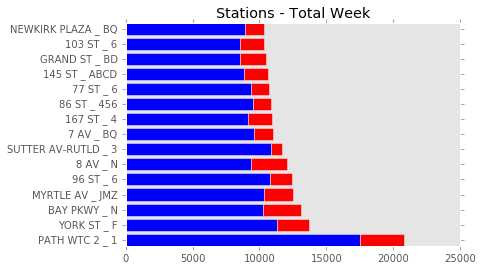

In [116]:

def print_sorted_graph(mta_turn, top, sort_val, color, title):
    if sort_val == 2:
        #stack bar graph
        plt.figure()
        sortedByKeyDict = sorted(mta_turn.items(), key = lambda x: x[1][sort_val], reverse=True)
        x1 = []
        x2 = []
        y = []
        my_yticks = []
        count = 0 
        for mta_keys, curVal in sortedByKeyDict[0:top]:
            x1.append(curVal[0])
            x2.append(curVal[1])
            my_yticks.append(mta_keys)
            y.append(count)
            count = count + 1

        width = 1/1.5
        plt.yticks(y, my_yticks)
        plt.barh(y, x1, label = 'Weekday', color='blue', align="center")
        plt.barh(y, x2, left = x1, label = 'Weekend', color='red', align="center")
        plt.title(title)
        plt.grid(False)
    else:
        plt.figure()
        sortedByKeyDict = sorted(mta_turn.items(), key = lambda x: x[1][sort_val], reverse=True)
        x = []
        y=[]
        my_yticks = []
        count = 0 
        for mta_keys, curVal in sortedByKeyDict[0:top]:
            x.append(curVal[sort_val])
            my_yticks.append(mta_keys)
            y.append(count)
            count = count + 1

        width = 1/1.5
        plt.yticks(y, my_yticks)
        plt.barh(y, x, color=color, align="center")
        plt.title(title)
        plt.grid(False)
    
print_sorted_graph(mta_neighbor, 15, 0, 'blue', 'Neighborhood - Weekday')
print_sorted_graph(mta_neighbor, 15, 1, 'red', 'Neighborhood - Weekend')
print_sorted_graph(mta_neighbor, 15, 2, 'green', 'Neighborhood - Total Week')
print_sorted_graph(mta_station, 15, 0, 'yellow', 'Stations - Weekday')
print_sorted_graph(mta_station, 15, 1, 'purple', 'Stations - Weekend')
print_sorted_graph(mta_station, 15, 2, 'black', 'Stations - Total Week')

# x2 in Chelsea
# x1 in Midtown East
# x1 Herald Square/Murray Hill


In [117]:
print mta_station['GRD CNTRL-42 ST _ 4567S']

[8898.539999999999, 946.2, 9844.74]
